# Trust in the Machine: How Contextual Factors and Personality Traits Shape Algorithm Aversion and Collaboration - Notebook 2 / 3.

## Machine Learning models implementation - Random Forest and Gradient Boosting Machines

**Authors:**<br>
Vinicius Ferraz - Alfred-Weber Institute for Economics, University of Heidelberg <br>
Christiane Schwieren - Alfred-Weber Institute for Economics, University of Heidelberg <br>
Leon Houf - Alfred-Weber Institute for Economics, University of Heidelberg <br>
Thomas Pitz - Faculty of Society and Economics, Rhine-Waal University<br>
Jörn Sickmann -  Faculty of Society and Economics, Rhine-Waal University

This Jupyter Notebook contains the reproduction of the machine learning models implemented in the paper. In case of any questions, plese contact Vinicius Ferraz (visferraz@gmail.com). 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

import numpy as np
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc, 
    mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score, make_scorer
)

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GroupKFold

%matplotlib inline
warnings.filterwarnings('ignore')

#### Data Parsing

In [12]:
# reading pre-processed merged dataset (generated from the Data Analysis file)
df_merged = pd.read_csv('data/df_merged_processed.csv')

In [50]:
# defining x and y variables for ALL models

dependent_var = ['delegation_bin']

independent_vars = ['explanation_d', 'payment_d', 'automation_d','female','stem','business_econ','age',
                    'extraversion','agreeableness', 'conscientiousness', 'neuroticism', 'openness', 'internal_loc',
                   'external_loc', 'trust', 'perception']

In [45]:
# Data split for training and predictions
df_train, df_test = train_test_split(df_merged, test_size=0.2, random_state=42)

### Logistic Regression Prediction Model

Prediction Benchmark using the Logistic Regression Model

In [32]:
# Data Split
X_train = df_train[independent_vars]
X_test = df_test[independent_vars]
y_train = df_train[dependent_var]
y_test = df_test[dependent_var]

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Model Fit
logit_model = sm.Logit(y_train, X_train)
result_logit = logit_model.fit()

# Predicted Classes
y_pred_class = [1 if x > 0.5 else 0 for x in y_pred]

# Performance Mterics
cm = confusion_matrix(y_test, y_pred_class)
acc = accuracy_score(y_test, y_pred_class)

TN, FP, FN, TP = cm.ravel()

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score_value = 2 * (precision * recall) / (precision + recall)

print()
print("Confusion Matrix:")
print(cm)
print()
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score_value)

Optimization terminated successfully.
         Current function value: 0.635435
         Iterations 5

Confusion Matrix:
[[ 739  636]
 [ 425 1000]]

Accuracy: 0.6210714285714286
Precision: 0.6112469437652812
Recall: 0.7017543859649122
F1 Score: 0.6533812479581836


### Machine Learning Models

Functions for model fitting and computation of metrics

In [48]:
# Random Forest Model Fit
def fit_random_forest(df_train, df_test, independent_vars, dependent_var, best_params):
    rf_clf = RandomForestClassifier(n_estimators=best_params['n_estimators'], 
                                     max_depth=best_params['max_depth'], 
                                     max_features=best_params['max_features'], 
                                     min_samples_leaf=best_params['min_samples_leaf'], 
                                     random_state=42,
                                     min_samples_split=best_params['min_samples_split'],
                                     bootstrap=best_params['bootstrap'], 
                                    class_weight=best_params['class_weight'],
                                    criterion=best_params['criterion'])
                                                          
    rf_clf.fit(df_train[independent_vars], df_train[dependent_var].values.ravel())

    y_pred = rf_clf.predict(df_test[independent_vars])

    return rf_clf, y_pred

# GBM Model Fit:
def fit_gradient_boosting(df_train, df_test, independent_vars, dependent_var, best_params):
    gb_clf = GradientBoostingClassifier(n_estimators=best_params['n_estimators'], 
                                       max_depth=best_params['max_depth'], 
                                       max_features=best_params['max_features'], 
                                       min_samples_leaf=best_params['min_samples_leaf'],
                                       learning_rate=best_params['learning_rate'],
                                       min_samples_split=best_params['min_samples_split'],
                                       subsample=best_params['subsample'],
                                       random_state=42)

    gb_clf.fit(df_train[independent_vars].values, df_train[dependent_var].values.ravel())

    y_pred = gb_clf.predict(df_test[independent_vars].values)

    return gb_clf, y_pred

# Performance metrics calculation:
def calculate_metrics(df_test, independent_vars, dependent_var, rf_model):
    metrics = {}
    y_test = df_test[dependent_var]
    y_pred = rf_model.predict(df_test[independent_vars])

    metrics['mse'] = mean_squared_error(y_test, y_pred)
    metrics['mae'] = mean_absolute_error(y_test, y_pred)
    metrics['rmse'] = mean_squared_error(y_test, y_pred, squared=False)

    scores = cross_val_score(rf_model, df_test[independent_vars], df_test[dependent_var], cv=5, 
                             scoring='neg_mean_squared_error')
    metrics['cv_rmse_scores'] = np.sqrt(-scores)
    
    y_pred_cat = y_pred > 0.5
    metrics['f1'] = f1_score(y_test > 0.5, y_pred_cat)
    metrics['precision'] = precision_score(y_test > 0.5, y_pred_cat)
    metrics['recall'] = recall_score(y_test > 0.5, y_pred_cat)
    metrics['confusion_mat'] = confusion_matrix(y_test > 0.5, y_pred_cat)
    metrics['accuracy'] = accuracy_score(y_test > 0.5, y_pred_cat)

    return metrics

# ROC-AUC calculation:
def calculate_roc_auc(rf_model, df_test, independent_vars, dependent_var):
    y_test = df_test[dependent_var]
    y_pred_proba = rf_model.predict_proba(df_test[independent_vars])[:, 1] 
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    return roc_auc, fpr, tpr

### Parameter Tuning

The functions below refer to the grid-search function for hyperparameter tuning. The computed values of our parameters are specified below. 

<font color='red'>VERY IMPORTANT:</font> Grid search operations are performance intensive and might take several hours or even days to run, so dont execute these functions if not necessary. 

In [26]:
def hyperparameter_tuning_rf(df_train, independent_vars, dependent_var):
    # grid definition
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [5, 10, 15, 20, 25, 30],
        'max_features': ['auto', 'sqrt', 'log2', None],
        'min_samples_leaf': [1, 2, 5, 10, 20],
        'min_samples_split': [2, 5, 10, 15, 20],
        'bootstrap': [True, False],
        'class_weight': ['balanced', 'balanced_subsample', None],
        'criterion': ['gini', 'entropy']
    }

    # base model
    rf = RandomForestClassifier(random_state=42)

    # GroupKFold cross-validator
    gkf = GroupKFold(n_splits=5)

    # instance the grid search model
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=gkf, n_jobs=-1, scoring='roc_auc')

    # fitting the grid search to the data (grouped on the participant level)
    grid_search.fit(df_train[independent_vars], df_train[dependent_var], groups=df_train['participant_code'])

    # get best parameters
    rf_params = grid_search.best_params_
    
    return rf_params

def hyperparameter_tuning_gbm(df_train, independent_vars, dependent_var):
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [5, 10, 15, 20, 25, 30],
        'max_features': ['auto', 'sqrt', 'log2', None],
        'min_samples_leaf': [1, 2, 5, 10, 20],
        'min_samples_split': [2, 5, 10, 15, 20],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    }
    gbm = GradientBoostingClassifier(random_state=42)
    gkf = GroupKFold(n_splits=5)
    grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=gkf, n_jobs=-1, scoring='roc_auc')
    grid_search.fit(df_train[independent_vars], df_train[dependent_var], groups=df_train['participant_code'])
    gbm_params = grid_search.best_params_
    return gbm_params

Uncomment these functions below if you want to run the grid search functions

In [ ]:
#%%time
#rf_params = hyperparameter_tuning_rf(df_train, independent_vars, dependent_var)
#print(rf_params)

In [1]:
#%%time
#gbm_params = hyperparameter_tuning_gbm(df_train, independent_vars, dependent_var)
#print(gbm_params)

Computed model parameters used in the paper:

In [36]:
rf_prams = {'bootstrap': True,
 'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [37]:
gbm_params = {'learning_rate': 0.05,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'n_estimators': 100,
 'subsample': 0.7}

### Models Fitting

In [38]:
# fit
rf_model, rf_y_pred = fit_random_forest(df_train, df_test, independent_vars, dependent_var, rf_prams)

In [39]:
gbm_model, gbm_y_pred = fit_gradient_boosting(df_train, df_test, independent_vars, dependent_var, gbm_params)

Performance metrics

In [40]:
metrics_rf = calculate_metrics(df_test, independent_vars, dependent_var, rf_model)
metrics_rf

{'mse': 0.1667857142857143,
 'mae': 0.1667857142857143,
 'rmse': 0.4083940673977945,
 'cv_rmse_scores': array([0.42678198, 0.45903626, 0.43915503, 0.42257713, 0.42468476]),
 'f1': 0.8405599180607716,
 'precision': 0.8184840425531915,
 'recall': 0.863859649122807,
 'confusion_mat': array([[1102,  273],
        [ 194, 1231]]),
 'accuracy': 0.8332142857142857}

In [41]:
metrics_gbm = calculate_metrics(df_test, independent_vars, dependent_var, gbm_model)
metrics_gbm

{'mse': 0.1675,
 'mae': 0.1675,
 'rmse': 0.40926763859362253,
 'cv_rmse_scores': array([0.4309458 , 0.45903626, 0.43711718, 0.41833001, 0.43506978]),
 'f1': 0.8413933040243491,
 'precision': 0.8120104438642297,
 'recall': 0.8729824561403509,
 'confusion_mat': array([[1087,  288],
        [ 181, 1244]]),
 'accuracy': 0.8325}

Area under the ROC curve:

In [49]:
auc_rf = calculate_roc_auc(rf_model, df_test, independent_vars, dependent_var)
auc_gbm = calculate_roc_auc(gbm_model, df_test, independent_vars, dependent_var)
print(auc_rf[0])
print(auc_gbm[0])

0.9176811483253587
0.9172281977671451


### Feature Importances

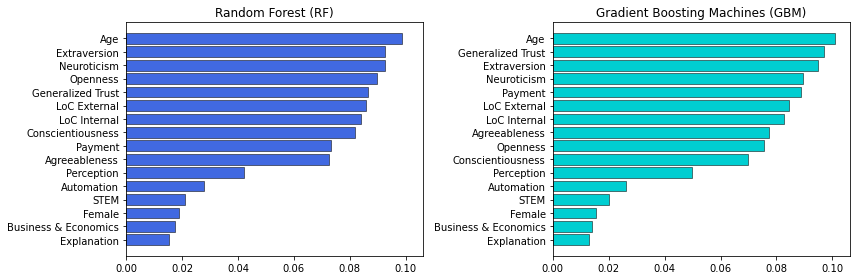

In [66]:
X_train = df_train[independent_vars]
importances_rf = rf_model.feature_importances_
importances_gbm = gbm_model.feature_importances_
feature_names = independent_vars

# Create mapping of original to new feature names
new_feature_names = {
    'explanation_d': 'Explanation', 
    'payment_d': 'Payment', 
    'automation_d': 'Automation', 
    'female': 'Female',
    'stem': 'STEM',
    'age': 'Age', 
    'extraversion': 'Extraversion', 
    'agreeableness': 'Agreeableness', 
    'conscientiousness': 'Conscientiousness',
    'neuroticism': 'Neuroticism', 
    'openness': 'Openness', 
    'internal_loc': 'LoC Internal', 
    'external_loc': 'LoC External',
    'trust': 'Generalized Trust',
    'perception': 'Perception',
    'business_econ': 'Business & Economics'
}

feature_names = np.array([new_feature_names.get(f, f) for f in feature_names])

indices_rf = np.argsort(importances_rf)[::1]
indices_gbm = np.argsort(importances_gbm)[::1]

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)  # Creates a figure with 1 row and 2 columns of subplots

# Plot for Random Forest
ax[0].barh(range(X_train.shape[1]), importances_rf[indices_rf], color='royalblue', edgecolor='black', linewidth=0.5)
ax[0].set_yticks(range(X_train.shape[1]))
ax[0].set_yticklabels(feature_names[indices_rf])
ax[0].set_title("Random Forest (RF)")

# Plot for Gradient Boosting Machine
ax[1].barh(range(X_train.shape[1]), importances_gbm[indices_gbm], color='darkturquoise',
           edgecolor='black', linewidth=0.5)
ax[1].set_yticks(range(X_train.shape[1]))
ax[1].set_yticklabels(feature_names[indices_gbm])
ax[1].set_title("Gradient Boosting Machines (GBM)")

plt.tight_layout()

### Combined ROC-AUC Curves 

In [69]:
# Generating multiple curves for all models
def calculate_roc_auc_plot(model, model_name, df_test, independent_vars, dependent_var):
    y_test = df_test[dependent_var]
    if model_name == 'Logistic Regression':
        X_test = sm.add_constant(df_test[independent_vars])
        y_pred_proba = model.predict(X_test)
    elif model_name == 'Support Vector Machine':
        X_test_scaled = scaler.transform(df_test[independent_vars])
        y_pred_proba = model.decision_function(X_test_scaled)
    else:
        y_pred_proba = model.predict_proba(df_test[independent_vars])[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    return roc_auc, fpr, tpr

# Plotting all curves in the same figure
def plot_roc_auc(models_dict, df_test, independent_vars, dependent_var):
    model_colors = {'Random Forest': 'royalblue', 'Gradient Boosting Machine': 'darkturquoise', 
                    'Logistic Regression': 'purple'}
    
    plt.figure(figsize=(6, 3.5))
    for model_name, model in models_dict.items():
        roc_auc, fpr, tpr = calculate_roc_auc_plot(model, model_name, df_test, independent_vars, dependent_var)
        plt.plot(fpr, tpr, color=model_colors[model_name], lw=1, 
                 label='{} (AUC = {:.3f})'.format(model_name, roc_auc))
    plt.plot([0, 1], [0, 1], color='dimgray', lw=1.2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.tight_layout()

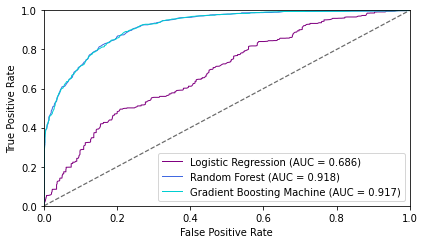

In [71]:
models_dict = {
    'Logistic Regression': result_logit,
    'Random Forest': rf_model,
    'Gradient Boosting Machine': gbm_model,
}

plot_roc_auc(models_dict, df_test, independent_vars, dependent_var)
plt.tight_layout()